# Customer Segmentation

### Key Insights:

#### 1. Customer Segments Identified:
- Cluster 0: Customers with very low recency, frequency, and monetary values (outliers with low engagement and spend).
- Cluster 1: The largest group, with high frequency and moderate spending, indicating regular and mid-range spenders.
- Cluster 2: Customers with extremely high monetary values and frequency, likely high-value repeat buyers or loyal customers.
- Cluster 3: Customers with low frequency but very high recency, suggesting occasional shoppers who make large purchases when they do.

#### 2. Customer Segmentation for Targeted Marketing:

You can design marketing campaigns specifically targeted at each segment:
- Cluster 0 (Low Engagement): Re-engagement strategies might be needed here.
- Cluster 1 (Mid-range Spend): Loyalty programs and product recommendations could be effective.
- Cluster 2 (High Spend, Frequent): Premium or VIP loyalty programs would be ideal.
- Cluster 3 (Occasional, High Value): Triggered campaigns or special offers to encourage repeat business.

#### 3. Revenue Optimization:
- Identifying your high-value customers (Cluster 2) can help direct resources to retaining them or creating upsell opportunities.
- Similarly, understanding low-frequency, low-spend customers (Cluster 0) could inform campaigns to increase their engagement.

#### 4. Improving Customer Experience:
- With clear segmentation, you can better cater to the unique needs of each group, offering tailored experiences and product recommendations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Unzipping and loading the Excel file
import zipfile
with zipfile.ZipFile('Online retail.zip', 'r') as zip_ref:
    zip_ref.extractall('Online_Retail')

# Load the Excel file into a DataFrame
df = pd.read_excel('Online_Retail/online_retail_II.xlsx')

# Data Exploration and Preprocessing
print(df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Missing values in the dataset:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int6

In [4]:
# Handling FutureWarning by avoiding inplace=True
df['Description'] = df['Description'].fillna('Unknown')  # Impute missing descriptions
df.dropna(subset=['Customer ID'], inplace=True)  # Drop rows with missing CustomerID

# Ensure 'Invoice' is treated as a string and handle missing values
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df['Invoice'].str.startswith('C', na=False)]  # Remove rows with cancellations

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Feature Engineering (Creating Recency, Frequency, and Monetary features)
current_date = df['InvoiceDate'].max()
df['Recency'] = (current_date - df['InvoiceDate']).dt.days

# Calculate TotalSpent (Quantity * Price)
df['TotalSpent'] = df['Quantity'] * df['Price']

# Frequency: Total number of transactions per customer
frequency = df.groupby('Customer ID')['Invoice'].nunique()

# Monetary: Total spent per customer
monetary = df.groupby('Customer ID')['TotalSpent'].sum()

# Create a new DataFrame for RFM features
rfm_df = pd.DataFrame({
    'Recency': df.groupby('Customer ID')['Recency'].min(),
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

# Scaling the Data for clustering
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]), 
                          columns=['Recency', 'Frequency', 'Monetary'])


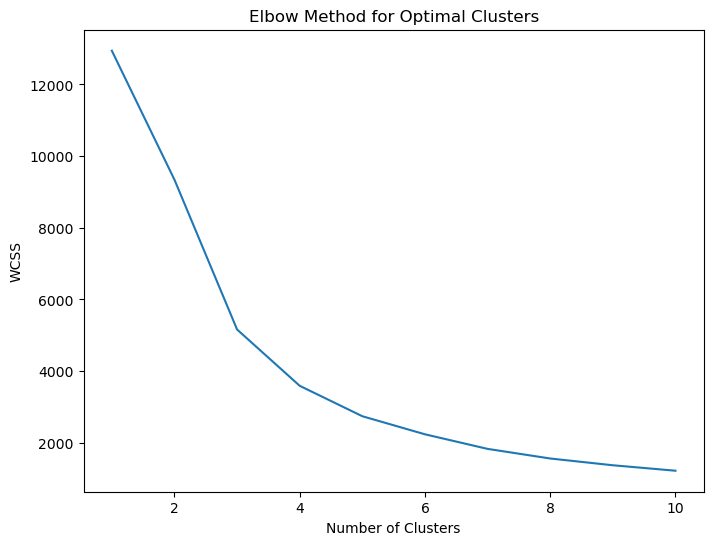

In [5]:
# Apply K-Means Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

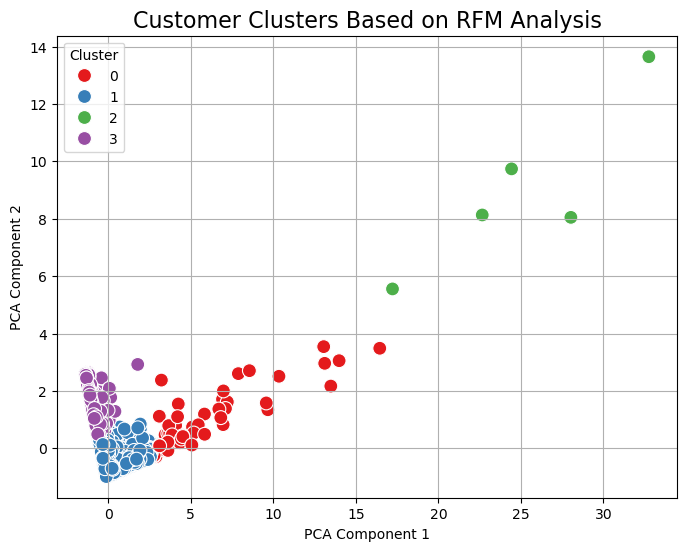

In [6]:
# PCA for Visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_df['Cluster'], palette='Set1', s=100)
plt.title('Customer Clusters Based on RFM Analysis', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [7]:
# Analyzing the Cluster Centers
cluster_centers = kmeans.cluster_centers_
original_centers = scaler.inverse_transform(cluster_centers)

# Create a DataFrame to view the cluster centers
cluster_centers_df = pd.DataFrame(original_centers, columns=['Recency', 'Frequency', 'Monetary'])
print(cluster_centers_df)

# Cluster Summary: Mean, Median, Std
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})
print(cluster_summary)

# Cluster Counts
cluster_counts = rfm_df['Cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)

      Recency   Frequency       Monetary
0   13.271186   46.033898   28018.434966
1   42.069978    4.433302    1710.796375
2    4.600000  113.600000  215543.670000
3  242.086749    1.658723     595.746486
            Recency                     Frequency                    \
               mean median        std        mean median        std   
Cluster                                                               
0         13.271186    3.0  34.983164   46.033898   38.0  29.692659   
1         42.069978   32.0  34.892130    4.433302    3.0   4.129997   
2          4.600000    6.0   4.335897  113.600000   94.0  51.829528   
3        242.086749  233.0  66.006022    1.658723    1.0   1.221555   

              Monetary                           
                  mean     median           std  
Cluster                                          
0         28018.434966   20329.68  19699.235589  
1          1710.796375     924.52   2320.354547  
2        215543.670000  196566.74  87157.722931